In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Input, concatenate as Concatenate
from keras.optimizers import SGD
from keras.metrics import Precision, Recall
import math
from sklearn.metrics import mean_squared_error

In [3]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [4]:
# First, we get the data
dataset = pd.read_csv('../input/ibmstock/IBM_with_twitterscore.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name,Score
Date,,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM,0.112745
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM,0.427281
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM,0.364548
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM,0.850125
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM,0.041936


In [5]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
training_set_tweet = dataset[:'2016'].iloc[:,6:7].values
print(len(training_set), len(training_set_tweet))
test_set = dataset['2017':].iloc[:,1:2].values
test_set_tweet = dataset[:'2016'].iloc[:,6:7].values

2769 2769


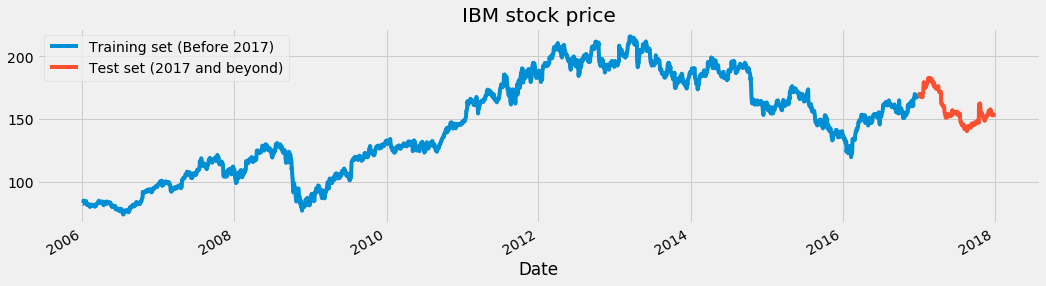

In [6]:
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [7]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
tweet_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
    tweet_train.append(training_set_tweet[i,0])
X_train, y_train, tweet_train = np.array(X_train), np.array(y_train), np.array(tweet_train)

In [9]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [23]:
# The GRU architecture
regressor = Sequential()
# First GRU layer with Dropout regularisation
regressor.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second GRU layer
regressor.add(GRU(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third GRU layer
regressor.add(GRU(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth GRU layer
regressor.add(GRU(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=20,batch_size=32)

Epoch 1/20
2709/2709 [==============================] - 10s 4ms/step - loss: 0.0119
Epoch 2/20
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0067
Epoch 3/20
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0055
Epoch 4/20
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0047
Epoch 5/20
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0046
Epoch 6/20
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0039
Epoch 7/20
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0038
Epoch 8/20
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0036
Epoch 9/20
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0034
Epoch 10/20
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0032
Epoch 11/20
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0029
Epoch 12/20
2709/2709 [==============================] - 9s 3ms/step - loss: 0.0028


In [24]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [31]:
# Preparing X_test and predicting the prices
X_test = []
tweet_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
    tweet_test.append(test_set_tweet[i, 0])
X_test, tweet_test = np.array(X_test), np.array(tweet_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

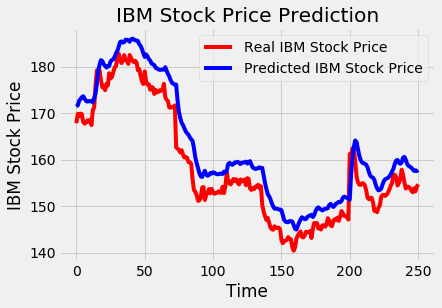

In [32]:
# Visualizing the results for GRU
plot_predictions(test_set,predicted_stock_price)

In [34]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 4.68478078362231.


In [19]:
stock_inputGRU = Input(shape=(X_train.shape[1],1), name="stock_input")

stock_outGRU = GRU(50, return_sequences=True)(stock_inputGRU)
stock_outGRU = Dropout(0.2)(stock_outGRU)

stock_outGRU = GRU(50, return_sequences=True)(stock_outGRU)
stock_outGRU = Dropout(0.2)(stock_outGRU)

stock_outGRU = GRU(50, return_sequences=True)(stock_outGRU)
stock_outGRU = Dropout(0.2)(stock_outGRU)

stock_outGRU = GRU(50)(stock_outGRU)
stock_outGRU = Dropout(0.2)(stock_outGRU)

stock_outGRU = Dense(1)(stock_outGRU)

tweet_inputGRU = Input(shape=(1,), name="tweet_input")

concatGRU = Concatenate([stock_outGRU, tweet_inputGRU])

concatGRU = Dense(64, activation='relu')(concatGRU)
concatGRU = Dense(64, activation='relu')(concatGRU)
concatGRU = Dense(64, activation='relu')(concatGRU)

outGRU = Dense(1, activation='sigmoid', name='main_output')(concatGRU)

modelGRU = Model(inputs=[stock_inputGRU, tweet_inputGRU], outputs=outGRU)
modelGRU.summary()

modelGRU.compile(optimizer='rmsprop',loss='mean_squared_error')
modelGRU.fit([X_train, tweet_train],y_train,epochs=20,batch_size=32)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stock_input (InputLayer)        (None, 60, 1)        0                                            
__________________________________________________________________________________________________
gru_9 (GRU)                     (None, 60, 50)       7800        stock_input[0][0]                
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 60, 50)       0           gru_9[0][0]                      
__________________________________________________________________________________________________
gru_10 (GRU)                    (None, 60, 50)       15150       dropout_9[0][0]                  
____________________________________________________________________________________________

In [20]:
predicted_stock_price = modelGRU.predict([X_test, tweet_test])
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

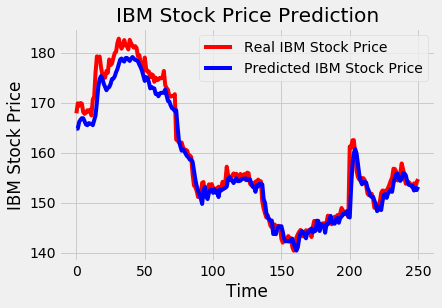

In [21]:
plot_predictions(test_set,predicted_stock_price)

In [22]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.42925716673559.
